In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

import analyze2p.decoding as dec

In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)

#### Main source
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'

In [4]:
%matplotlib notebook

In [5]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [7]:
#### Set trace ID and FOV/state type
experiment = 'gratings'
response_type='dff'
responsive_test='nstds'
traceid = 'traces001'
trial_epoch='stimulus' #'stimulus'
# ----------------------------------------------------------------
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                if not meta.query('@va == visual_area and @dk == datakey').empty])
# Neural data
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 

traces001|dff_responsive-nstds-thr10.00
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
Checking gratings configs


# Example BY_NCELLS

#### Test sampling

In [9]:
n_cells_sample=4

In [8]:
cells0 = dec.get_all_responsive_cells(cells0, NDATA0)

In [9]:
meta = sdata[sdata.experiment=='gratings'].copy()
dkey_list = meta['datakey'].unique()
SDF, incorrect = aggr.check_sdfs_gratings(dkey_list, return_incorrect=True)
SDF['config'] = SDF.index.tolist()

Checking gratings configs


In [10]:
incorrect

['20190314_JC070_fov1',
 '20190315_JC070_fov2',
 '20190319_JC067_fov1',
 '20190321_JC070_fov2',
 '20190522_JC089_fov1',
 '20190527_JC092_fov3',
 '20190512_JC083_fov1',
 '20190513_JC078_fov1',
 '20190517_JC083_fov1',
 '20190511_JC083_fov1']

<IPython.core.display.Javascript object>


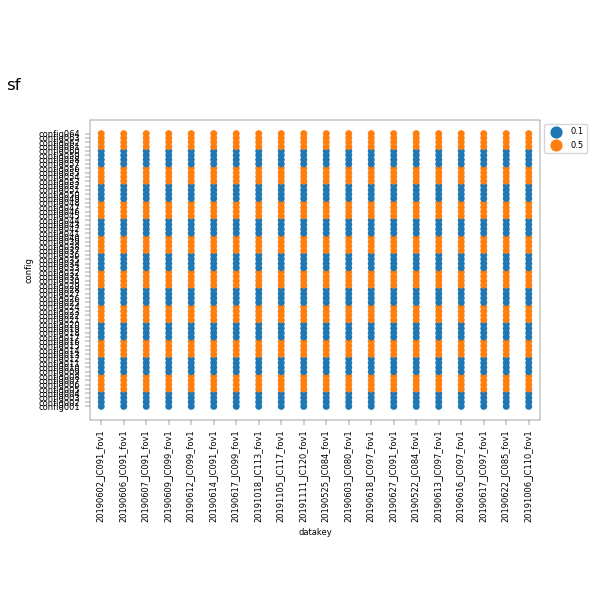

<IPython.core.display.Javascript object>


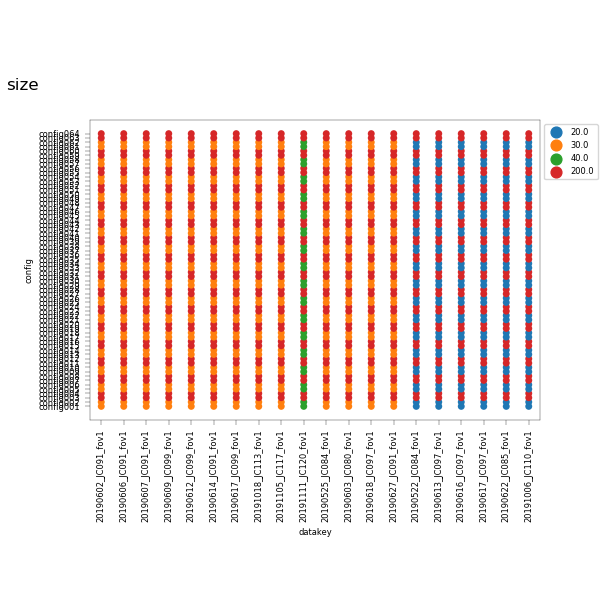

<IPython.core.display.Javascript object>


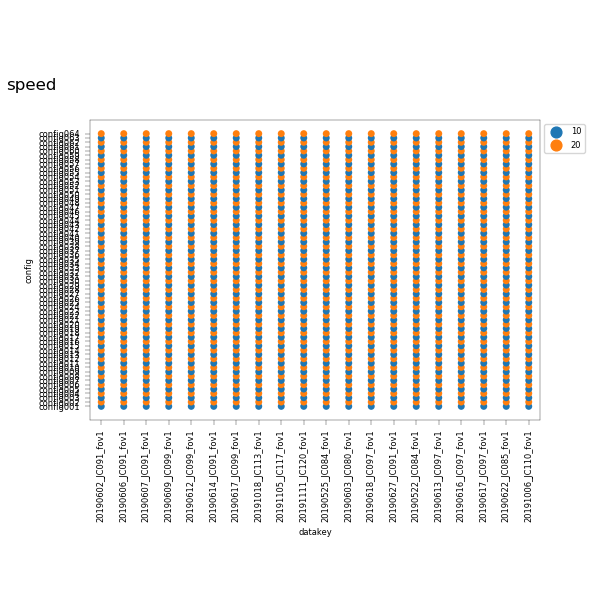

In [11]:
%matplotlib notebook
for param in ['sf', 'size', 'speed']:
    test_sd = SDF[[param, 'datakey', 'config']].drop_duplicates().copy()
    fig, ax = pl.subplots(figsize=(6,6))
    sns.stripplot(x='datakey', y='config', hue=param, data=test_sd, ax=ax, jitter=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    pl.subplots_adjust(left=0.15, right=0.9, bottom=0.3, top=0.8)
    fig.text(0.01, 0.85, param, fontsize=12)

#### rename old results_id dirs

In [194]:
import shutil

In [199]:
# Get rid of OLDDD (pre-rat2p) stuff
# for rdir in dirs_rename:
#     tracebase = rdir.split('/decoding_test')[0]
#     oldold_dir = os.path.join(tracebase, 'decoding')
#     old_dir = os.path.join(tracebase, '_decoding')
#     if os.path.exists(oldold_dir):
#         os.rename(oldold_dir, old_dir)

In [208]:
curr_test_str = 'size_subset'

experiment='blobs'
dirs_rename = glob.glob(os.path.join(rootdir, 'JC*', '2019*', 'FOV*', 
                      'combined_%s*' % experiment, 'traces/traces*',
                      'decoding_test', curr_test_str))
class_name = 'morphlevel' if experiment=='blobs' else 'ori'
print(len(dirs_rename))

43


In [209]:
for rdir in dirs_rename:
    tracebase = rdir.split('/decoding_test')[0]
    new_dir = os.path.join(tracebase, 'decoding', class_name, curr_test_str)
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    curr_fns = glob.glob(os.path.join(rdir,'*.pkl'))
    for fn in curr_fns:
        fname = os.path.split(fn)[-1]
        new_fpath = os.path.join(new_dir, fname)
        shutil.move(fn, new_fpath)


In [210]:
# Delete OLD dir
for rdir in dirs_rename:
    shutil.rmtree(rdir)

In [213]:
for rdir in dirs_rename:
    olddir = os.path.split(rdir)[0]
    shutil.rmtree(olddir)

In [217]:
fdir = os.path.join(aggregate_dir, 'decoding', 'py3_by_ncells', 'default', 'files')
fpaths = glob.glob(os.path.join(fdir, '*dff-nstds__plushalf__matchRF*.pkl'))
new_dir = os.path.join(aggregate_dir, 'decoding', 'py3_by_ncells', 'ori', 
                       'default', 'files')
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

for f in fpaths:
    fname = os.path.split(f)[-1]
    new_fpath = os.path.join(new_dir, fname)
    shutil.move(f, new_fpath)

In [84]:
print(experiment)
# dk = '20190315_JC070_fov1'
# va = 'Li'
dk = '20191006_JC110_fov1'
va = 'V1'
nmetrics = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk)].copy()
# stimuli
match_stimulus_names=experiment=='blobs'
sdf = aggr.get_stimuli(dk, experiment, match_names=match_stimulus_names)
# zscore data
ndf_z = aggr.get_zscored_from_ndf(nmetrics)
n_cells = int(ndf_z.shape[1]-1) 
print("... BY_FOV [%s] %s, n=%i cells" % (va, dk, n_cells))

gratings
... BY_FOV [V1] 20191006_JC110_fov1, n=93 cells


In [168]:
class_name = 'sf'
if class_name=='sf':
    sdf[class_name] = (sdf[class_name]*10).astype(int)
class_values = sorted((sdf[class_name].unique()))
print(class_name, class_values)

sf [1, 5]


In [169]:
varation_name = 'non_%s' % class_name
all_params=['ori', 'sf', 'size', 'speed']
nonX_params = [x for x in all_params if x!=class_name]
nonX_df = sdf[nonX_params].drop_duplicates()

In [170]:
variation_name = 'non_%s' % class_name
variation_values=None
#sdf[variation_name]=None
sdf.loc[sdf.index, variation_name] = ['%.1f_%.1f_%.1f' % (v1, v2, v3) for v1, v2, v3
                                         in sdf[nonX_params].values]
sdf.head()

,direction,luminance,stimtype,xpos,ypos,aspect,ori,position,speed,sf,size,non_sf
config001,0,None,gratings,30.0,0.0,1,0,"(30, 0)",10,1,20.0,0.0_20.0_10.0
config002,0,None,gratings,30.0,0.0,1,0,"(30, 0)",20,1,20.0,0.0_20.0_20.0
config003,0,None,gratings,30.0,0.0,1,0,"(30, 0)",10,1,200.0,0.0_200.0_10.0
config004,0,None,gratings,30.0,0.0,1,0,"(30, 0)",20,1,200.0,0.0_200.0_20.0
config005,0,None,gratings,30.0,0.0,1,0,"(30, 0)",10,5,20.0,0.0_20.0_10.0


In [171]:
for ix, train_parvals in nonX_df.iterrows():
    train_parvals

In [172]:
# pd.merge(nonori_df.iloc[0], sdf, how='left', l
#          eft_on=nonori_params, right_on=nonori_params)
sdf[sdf[nonX_params].eq(train_parvals).all(axis=1)]

,direction,luminance,stimtype,xpos,ypos,aspect,ori,position,speed,sf,size,non_sf
config060,0,None,gratings,30.0,0.0,1,315,"(30, 0)",20,1,200.0,315.0_200.0_20.0
config064,0,None,gratings,30.0,0.0,1,315,"(30, 0)",20,5,200.0,315.0_200.0_20.0


In [173]:
C_value=1.0
test_split=0.2
cv_nfolds=5
n_iterations = 1
n_processes=1

in_args={'class_name': class_name,
            'class_values': class_values,
            'variation_name': variation_name,
            'variation_values': variation_values,
            'n_train_configs': None,
            'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'balance_configs':True,
            'do_shuffle': True,
            }
            #'return_clf': False,
            #'verbose': False}

In [174]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [175]:
ndf_z.head()

cell,0,5,7,18,19,23,28,29,31,32,...,269,281,288,301,302,312,313,320,328,config
trial,,,,,,,,,,,,,,,,,,,,,
1,0.198689,3.372258,1.310275,1.669478,1.158809,2.800322,6.023257,2.217898,0.504524,9.150741,...,-0.369457,7.231100,2.860498,1.949620,1.949697,-0.246776,2.542552,2.919298,2.170832,config026
2,-1.362432,1.723504,-1.045571,-1.394124,-0.989003,-1.069636,-3.090945,0.945653,0.545892,2.909722,...,1.135723,2.547383,0.642592,-1.309637,-0.203067,2.864497,0.110992,1.441736,-0.465756,config010
3,0.386804,-0.476859,1.586870,0.061612,-0.146710,0.491951,-0.082925,-0.442365,-0.657308,-2.497822,...,-1.276496,-0.337232,-2.111805,-1.823482,0.097954,-0.630645,-1.190312,-0.976449,-0.591894,config064
4,0.059929,2.814610,1.285745,0.845159,2.511355,2.534427,2.066325,2.390148,2.591599,1.591087,...,0.578508,3.064076,-1.760332,2.517116,2.379207,1.636816,1.598476,-0.508890,0.164988,config049
5,0.008623,0.641584,-0.977096,-0.310822,-0.014717,0.959728,1.442825,0.163926,-0.182029,-0.957050,...,0.088890,-0.915419,0.197938,-0.502631,0.009305,-1.633086,0.371755,-0.589681,-1.799340,config016


In [176]:
nmetrics

,datakey,config,trial,visual_area,cell,response,experiment
0,20191006_JC110_fov1,config026,1,V1,0,0.022230,gratings
1,20191006_JC110_fov1,config010,2,V1,0,-0.106479,gratings
2,20191006_JC110_fov1,config064,3,V1,0,0.037739,gratings
3,20191006_JC110_fov1,config049,4,V1,0,0.010790,gratings
4,20191006_JC110_fov1,config016,5,V1,0,0.006560,gratings
...,...,...,...,...,...,...,...
119035,20191006_JC110_fov1,config036,1276,V1,328,0.020701,gratings
119036,20191006_JC110_fov1,config020,1277,V1,328,-0.000334,gratings
119037,20191006_JC110_fov1,config046,1278,V1,328,-0.011393,gratings
119038,20191006_JC110_fov1,config050,1279,V1,328,-0.012264,gratings


In [177]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [178]:
train_configs = sdf[sdf[class_name].isin(class_values)].index.tolist()
sample_data = curr_data[curr_data['config'].isin(train_configs)]
sample_data = aggr.equal_counts_df(sample_data)
zdata = sample_data.drop('config', 1)
targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
targets['label'] = [sdf[class_name][cfg] for cfg in targets['config'].values]
targets['label'].unique()

array([1, 5])

In [181]:
clf_params = {'C_value': C_value,
              'cv_nfolds': cv_nfolds,
              'test_split': test_split,
              'randi': 100,
              'inum': iter_num}

In [182]:
iter_num=2
# curr_data = ndf_z.copy()
#res = dec.decode_from_fov(dk, experiment, nmetrics, sdf, verbose=True, **in_args)
#res = dec.select_test(iter_num, None, ndf_z, sdf, False, verbose=True, **in_args)
res = dec.do_fit_within_fov(iter_num, ndf_z, sdf, verbose=True, **in_args)
#idf_ = dec.fit_svm(zdata, targets, **clf_params)
res

Unique train: [1 5] (1024)
... train (C=1.00): 0.92, test: 0.85
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           1       0.85      0.85      0.85       128
           5       0.85      0.85      0.85       128

    accuracy                           0.85       256
   macro avg       0.85      0.85      0.85       256
weighted avg       0.85      0.85      0.85       256

Unique train: [1 5] (1024)
... train (C=1.00): 0.65, test: 0.47
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           1       0.49      0.51      0.50       128
           5       0.49      0.48      0.48       128

    accuracy                           0.49       256
   macro avg       0.49      0.49      0.49       256
weigh

,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,condition,n_cells,n_trials,iteration
2,0.147973,0.002486,0.845681,0.915283,0.851562,1.0,1178,data,93,1280,2
2,0.335128,0.006359,0.467795,0.645021,0.492188,1.0,1178,shuffled,93,1280,2


In [102]:
for ix, train_parvals in nonX_df.iterrows():
    curr_sdf = sdf[sdf[nonX_params].eq(train_parvals).all(axis=1)].copy()
    train_configs = curr_sdf[curr_sdf[class_name].isin(class_values)].index.tolist()
    print(len(train_configs))

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


# With RFs

In [127]:
import analyze2p.receptive_fields.utils as rfutils

In [228]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [229]:
rf_lim = 'percentile'
# cells_lim = dec.get_cells_with_matched_rfs(cells0, sdata, rf_lim='percentile')
rfdf = dec.get_rfdf(cells0, sdata, do_spherical_correction=False)
cells_RF = dec.get_cells_with_rfs(cells0, rfdf)
cells_lim, sz_limits = dec.limit_cells_by_rf(cells_RF, rf_lim=rf_lim)

N dpaths: 62, N unfit: 0
N datasets included: 67, N sessions excluded: 4


In [230]:
print(cells_RF[['visual_area', 'datakey', 'cell']].drop_duplicates()\
      ['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |          1119 |
| Li |           597 |
| Lm |           446 |


In [231]:
sz_lower, sz_upper = sz_limits.loc['lower'].max(), sz_limits.loc['upper'].min()
sz_limits

,Li,Lm,V1
lower,13.869418,1.958139,7.328274
upper,53.887003,51.883686,39.171562


In [232]:
dst_dir = os.path.join(aggregate_dir, 'decoding', 'py3_controls')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    print(dst_dir)

<IPython.core.display.Javascript object>


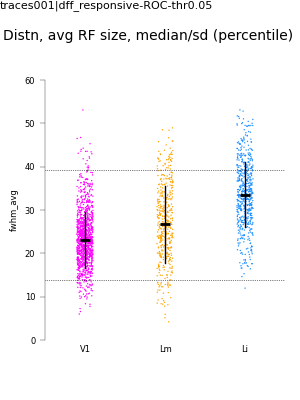

In [251]:
%matplotlib notebook
fig, ax = pl.subplots(figsize=(3,4))
sns.stripplot(x='visual_area', y='fwhm_avg', hue='visual_area', 
             data=cells_RF, ax=ax, order=visual_areas, 
             palette=area_colors, s=1, zorder=0)
sns.pointplot(x='visual_area', y='fwhm_avg',
             data=cells_RF, ax=ax, order=visual_areas, join=False, ci='sd',
             estimator=np.median, color='k', markers='_', scale=1, zorder=1000,
             errwidth=1)
ax.set_ylim([0, 60])
ax.set_xlabel('')
ax.tick_params(which='both', axis='x', size=0)
# sz_upper_lim=16.6
# sz_lower_lim=6.9
ax.axhline(y=sz_lower, color='k', ls=':', lw=0.5)
ax.axhline(y=sz_upper, color='k', ls=':', lw=0.5)
ax.legend_.remove()
sns.despine(bottom=True, trim=True)
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.8)

fig.text(0.01, 0.9, 'Distn, avg RF size, median/sd (%s)' % rf_lim)
pplot.label_figure(fig, data_id)
pl.savefig(os.path.join(dst_dir, 'RF_sizes_%s.svg' % rf_lim))

In [234]:
do_spherical_correction=False
response_type='dff'
cells_match = dec.get_cells_with_matched_rfs(cells0, sdata, rf_lim=rf_lim,
                                    response_type=response_type,
                                    do_spherical_correction=do_spherical_correction)


N dpaths: 62, N unfit: 0
N datasets included: 67, N sessions excluded: 4


In [235]:
NDATA = pd.concat([NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk)\
                        & (NDATA0['cell'].isin(g['cell'].unique()))]\
                for (va, dk), g in cells_match.groupby(['visual_area', 'datakey'])])

In [236]:
counts = NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area', 'datakey'])['cell'].count().reset_index()\
            .rename(columns={'cell': 'n_included'})
counts1 = NDATA0[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area', 'datakey'])['cell'].count().reset_index()\
            .rename(columns={'cell': 'n_responsive'})

In [237]:
print(counts.shape, counts1.shape)
total_counts = pd.merge(counts, counts1)

(38, 3) (53, 3)


In [238]:
total_counts['fraction_included'] = total_counts['n_included']/total_counts['n_responsive']
total_counts.head()

,visual_area,datakey,n_included,n_responsive,fraction_included
0,Li,20190602_JC091_fov1,40,87,0.459770
1,Li,20190606_JC091_fov1,11,48,0.229167
2,Li,20190607_JC091_fov1,17,52,0.326923
3,Li,20190609_JC099_fov1,22,57,0.385965
4,Li,20190612_JC099_fov1,13,38,0.342105


<IPython.core.display.Javascript object>


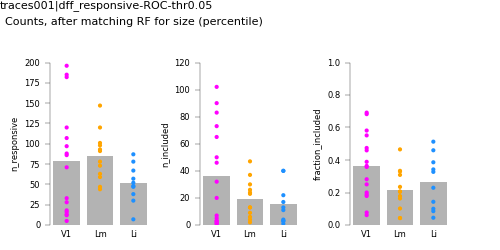

In [241]:
fig, axn = pl.subplots(1,3, figsize=(5,2.5), )
for ax, metric in zip(axn.flat, ['n_responsive', 'n_included', 'fraction_included']):
    sns.barplot(x='visual_area', y=metric, data=total_counts, ax=ax,
               color=[0.7]*3, order=visual_areas, ci=None)
    sns.stripplot(x='visual_area', y=metric, data=total_counts, ax=ax,
               hue='visual_area', order=visual_areas, palette=area_colors, size=3,
               jitter=False)
    if metric=='n_responsive':
        ax.set_ylim([0, 200])
    elif metric=='n_included':
        ax.set_ylim([0, 120])
    else:
        ax.set_ylim([0, 1])
    ax.set_xlabel('')
    ax.tick_params(which='both', axis='x', size=0)
    ax.legend_.remove()
sns.despine(bottom=True, trim=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.75, wspace=0.5)

fig.text(0.01, 0.9, 'Counts, after matching RF for size (%s)' % rf_lim, fontsize=8)

pplot.label_figure(fig, data_id)

pl.savefig(os.path.join(dst_dir, 'counts_after_match_rfs.svg'))

In [205]:
total_counts['fraction_included'].min()

0.0425531914893617

# Example BY_FOV

In [124]:
print(experiment)
# dk = '20190315_JC070_fov1'
# va = 'Li'
dk = '20191006_JC110_fov1'
va = 'V1'

nmetrics = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk)].copy()

# stimuli
match_stimulus_names=experiment=='blobs'
sdf = aggr.get_stimuli(dk, experiment, match_names=match_stimulus_names)
# zscore data
ndf_z = aggr.get_zscored_from_ndf(nmetrics)
n_cells = int(ndf_z.shape[1]-1) 
print("... BY_FOV [%s] %s, n=%i cells" % (va, dk, n_cells))

gratings
... BY_FOV [V1] 20191006_JC110_fov1, n=93 cells


In [125]:
# ndf_z = dec.shuffle_trials(ndf_z)
# ndf_z.head()

In [126]:
cfgs = ndf_z['config'].values
n_trials=ndf_z.shape[0]
rois_ = [r for r in ndf_z.columns if hutils.isnumber(r)]
len(rois_)

93

In [130]:
class_name='morphlevel' if experiment=='blobs' else 'sf'
class_a = 0 if class_name=='morphlevel' else None
class_b = 106 if class_name=='morphlevel' else None

class_values = [class_a, class_b] if class_name=='morphlevel' \
            else sdf[class_name].unique()
print(class_name, class_values)

variation_name=None
variation_values=None
if variation_name is not None:
    variation_values=sorted(sdf[variation_name].unique())

sf [0.1 0.5]


In [131]:
class_name = 'sf'

C_value=1.0
test_split=0.2
cv_nfolds=5
n_iterations = 1
n_processes=1

in_args={'class_name': class_name,
            'class_values': class_values,
            'variation_name': variation_name,
            'variation_values': variation_values,
            'n_train_configs': None,
            'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'balance_configs':True,
            'do_shuffle': True}
            #'return_clf': False,
            #'verbose': False}

In [132]:
import copy
inargs = copy.copy(in_args)


In [133]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

#### Highest level

In [134]:
inum=3
break_correlations=False
test_type=None #'morph_single'

i_df = dec.fit_svm_mp(ndf_z, sdf, test_type, n_iterations=10, n_processes=1, 
                      break_correlations=False, **in_args)


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/sklearn/svm/_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/sklearn/svm/_base.py", line 553, in _validate_targets
    check_classification_targets(y)
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/sklearn/utils/multiclass.py", line 183, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'conti

***Terminating!


UnboundLocalError: local variable 'iterdf' referenced before assignment

In [264]:
i_df[i_df['condition']=='data'].mean()

fit_time                 0.352946
score_time               0.007831
test_score               0.256054
train_score              0.836745
heldout_test_score       0.244141
C                        1.000000
randi                 4171.600000
n_cells                 93.000000
n_trials              1280.000000
iteration                4.500000
dtype: float64

In [76]:
# import _pickle as pkl
# fn=glob.glob(os.path.join('/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/combined_blobs_static/traces/traces001*', 
#         'decoding_test/morph_single/*.pkl'))[0]
# with open(fn, 'rb') as f:
#     res = pkl.load(f)

In [262]:
res.groupby(['iteration']).count()

,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,p_chooseB,morphlevel,n_samples,condition,train_transform,test_transform,novel,n_trials
iteration,,,,,,,,,,,,,,,
0,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
1,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
2,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
3,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
4,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
5,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
6,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
7,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
8,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500


<IPython.core.display.Javascript object>


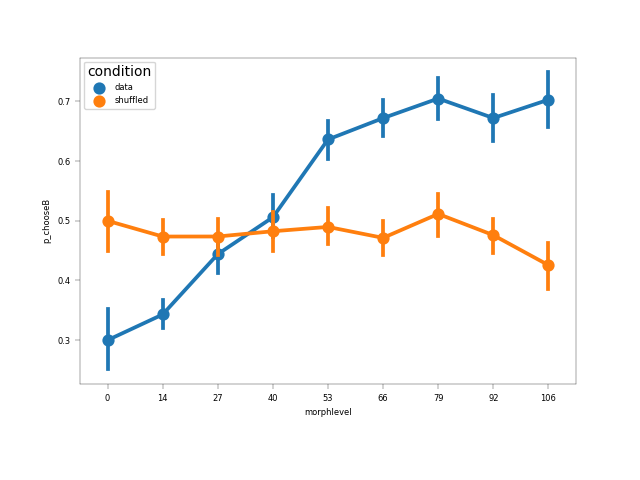

In [77]:
%matplotlib notebook
plotd =i_df[i_df['morphlevel']!=-1]

data_curve = plotd.sort_values(by='morphlevel')

fig, ax = pl.subplots()
sns.pointplot(x='morphlevel', y='p_chooseB', hue='condition', data=data_curve, ax=ax)
pl.subplots_adjust(bottom=0.2)

#### select_test()

In [ ]:
test_type

In [140]:
inum=3
break_correlations=False
test_type='morph_single'

# i_df = dec.select_test(inum, test_type, ndf_z, sdf, break_correlations, **in_args)
# i_df

In [141]:
res = dec.fit_svm_mp(ndf_z, sdf, test_type, n_iterations=10, n_processes=1,
              **in_args)

In [142]:
res[['train_score', 'test_score', 'heldout_test_score', 'condition']].groupby(['condition']).describe()

train_score                                    test_score            \
                count mean  std  min  25%  50%  75%  max      count      mean   
condition                                                                       
data           2500.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     2500.0  0.712545   
shuffled       2500.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     2500.0  0.704167   

           ...                     heldout_test_score                      \
           ...       75%       max              count      mean       std   
condition  ...                                                              
data       ...  0.767273  0.901818             2500.0  0.565053  0.200866   
shuffled   ...  0.763636  0.901818             2500.0  0.503245  0.137810   

                                                   
           min       25%       50%       75%  max  
condition                                          
data       0.0  0.424242  0.558824  0.714286  1.0  
shuffled   0.0  0.411765  0.500000  0.588235  1.0  

[2 rows x 24 columns]

## test_type='morph_single'

In [119]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [120]:
inum =2
clf_params={'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            #'randi': 10,
            'verbose': False}
#             'inum': inum}
res = dec.train_test_morph_single(inum, curr_data=ndf_z, sdf=sdf, 
                     **in_args)

In [121]:
res.groupby(['condition', 'train_transform', 'test_transform', 'morphlevel']).count()

fit_time  score_time  test_score  \
condition train_transform novel morphlevel                                     
data      10.0            False -1                 1           1           1   
                                 0                 1           1           1   
                                 14                1           1           1   
                                 27                1           1           1   
                                 40                1           1           1   
...                                              ...         ...         ...   
shuffled  50.0            True   53                4           4           4   
                                 66                4           4           4   
                                 79                4           4           4   
                                 92                4           4           4   
                                 106               4           4           4   

                                            train_score  heldout_test_score  \
condition train_transform novel morphlevel                                    
data      10.0            False -1                    1                   1   
                                 0                    1                   1   
                                 14                   1                   1   
                                 27                   1                   1   
                                 40                   1                   1   
...                                                 ...                 ...   
shuffled  50.0            True   53                   4                   4   
                                 66                   4                   4   
                                 79                   4                   4   
                                 92                   4                   4   
                                 106                  4                   4   

                                            C  randi  p_chooseB  n_samples  \
condition train_transform novel morphlevel                                   
data      10.0            False -1          1      1          1          1   
                                 0          1      1          1          1   
                                 14         1      1          1          1   
                                 27         1      1          1          1   
                                 40         1      1          1          1   
...                                        ..    ...        ...        ...   
shuffled  50.0            True   53         4      4          4          4   
                                 66         4      4          4          4   
                                 79         4      4          4          4   
                                 92         4      4          4          4   
                                 106        4      4          4          4   

                                            test_transform  n_trials  \
condition train_transform novel morphlevel                             
data      10.0            False -1                       1         1   
                                 0                       1         1   
                                 14                      1         1   
                                 27                      1         1   
                                 40                      1         1   
...                                                    ...       ...   
shuffled  50.0            True   53                      4         4   
                                 66                      4         4   
                                 79                      4         4   
                                 92                      4         4   
                                 106                     4         4   

                       

In [143]:
res[~res['novel']].groupby(['test_transform', 'morphlevel']).count()

fit_time  score_time  test_score  train_score  \
test_transform morphlevel                                                  
10.0           -1                20          20          20           20   
                0                20          20          20           20   
                14               20          20          20           20   
                27               20          20          20           20   
                40               20          20          20           20   
                53               20          20          20           20   
                66               20          20          20           20   
                79               20          20          20           20   
                92               20          20          20           20   
                106              20          20          20           20   
20.0           -1                20          20          20           20   
                0                20          20          20           20   
                14               20          20          20           20   
                27               20          20          20           20   
                40               20          20          20           20   
                53               20          20          20           20   
                66               20          20          20           20   
                79               20          20          20           20   
                92               20          20          20           20   
                106              20          20          20           20   
30.0           -1                20          20          20           20   
                0                20          20          20           20   
                14               20          20          20           20   
                27               20          20          20           20   
                40               20          20          20           20   
                53               20          20          20           20   
                66               20          20          20           20   
                79               20          20          20           20   
                92               20          20          20           20   
                106              20          20          20           20   
40.0           -1                20          20          20           20   
                0                20          20          20           20   
                14               20          20          20           20   
                27               20          20          20           20   
                40               20          20          20           20   
                53               20          20          20           20   
                66               20          20          20           20   
                79               20          20          20           20   
                92               20          20          20           20   
                106              20          20          20           20   
50.0           -1                20          20          20           20   
                0                20          20          20           20   
                14               20          20          20           20   
                27               20          20          20           20   
                40               20          20          20           20   
                53               20          20          20           20   
                66               20          20          20           20   
                79               20          20          20           20   
                92               20          20          20           20   
                106              20          20          20           20   

                           heldout_test_score   C  randi  p_chooseB  \
tes

In [144]:
res[(res['morphlevel'].isin([0, 106])) & (res.condition=='data')].sort_values(by=['train_transform', 'test_transform', 'novel'])

,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,p_chooseB,morphlevel,n_samples,condition,train_transform,test_transform,novel,n_trials,iteration
0,0.001192,0.000409,0.558182,1.0,0.428571,1.0,7197,0.428571,0,7,data,10.0,10.0,False,68,0
1,0.001192,0.000409,0.558182,1.0,0.428571,1.0,7197,0.285714,106,7,data,10.0,10.0,False,68,0
0,0.000906,0.000338,0.552727,1.0,0.500000,1.0,8823,0.285714,0,7,data,10.0,10.0,False,68,1
1,0.000906,0.000338,0.552727,1.0,0.500000,1.0,8823,0.285714,106,7,data,10.0,10.0,False,68,1
0,0.000904,0.000341,0.540000,1.0,0.571429,1.0,9262,0.428571,0,7,data,10.0,10.0,False,68,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0.000845,0.000342,0.727273,1.0,0.500000,1.0,5945,0.428571,106,7,data,50.0,50.0,False,66,7
400,0.000811,0.000336,0.752727,1.0,0.857143,1.0,650,0.285714,0,7,data,50.0,50.0,False,66,8
401,0.000811,0.000336,0.752727,1.0,0.857143,1.0,650,1.000000,106,7,data,50.0,50.0,False,66,8
400,0.000848,0.000339,0.730909,1.0,0.857143,1.0,7763,0.000000,0,7,data,50.0,50.0,False,66,9


<IPython.core.display.Javascript object>


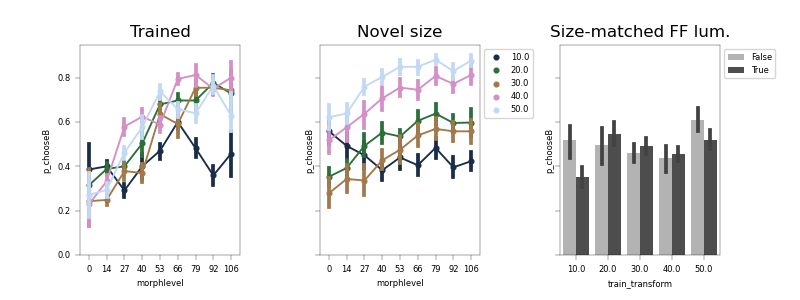

In [164]:
%matplotlib notebook
cmap='cubehelix'

plotd = res[res['morphlevel']!=-1].copy()
fig, axn = pl.subplots(1,3, figsize=(8,3), sharey=True)


ax=axn[0]
ax.set_title('Trained')
sns.pointplot(x='morphlevel', y='p_chooseB', hue='train_transform', 
             data=plotd[(plotd['condition']=='data')
                      & (~plotd['novel'])], ax=ax, palette=cmap,
             scale=0.5)
ax.legend_.remove()

ax=axn[1]
ax.set_title('Novel size')
sns.pointplot(x='morphlevel', y='p_chooseB', hue='train_transform', 
             data=plotd[(plotd['condition']=='data')
                      & (plotd['novel'])], ax=ax, palette=cmap,
             scale=0.5)
ax.legend(bbox_to_anchor=(1,1), loc='upper left', fontsize=6)

ax=axn[2]
ax.set_title('Size-matched FF lum.')
plotd = res[res['morphlevel']==-1].copy()
sns.barplot(x='train_transform', y='p_chooseB', hue='novel',
          data=plotd[plotd['condition']=='data'], ax=ax,
           palette={True: [0.3]*3, False: [0.7]*3})
ax.legend(bbox_to_anchor=(1,1), loc='upper left', fontsize=6)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.8, wspace=0.5)


In [28]:
res['test_transform'].unique()

array([10., 14., 27., 40., 53., 66., 79., 92., 20., 30., 50.])

## test_type='morph'

In [308]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [309]:
inum =2
clf_params={'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            #'randi': 10,
            'verbose': False}
#             'inum': inum}
res = dec.train_test_morph(inum, curr_data=ndf_z, sdf=sdf, 
                     **in_args)


<IPython.core.display.Javascript object>


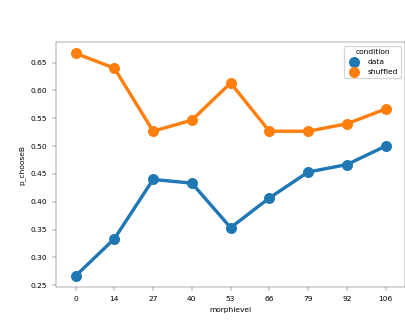

In [312]:
%matplotlib notebook
plotd =i_df[i_df['morphlevel']!=-1]

data_curve = plotd.sort_values(by='morphlevel')

fig, ax = pl.subplots()
sns.pointplot(x='morphlevel', y='p_chooseB', hue='condition', data=data_curve, ax=ax)
pl.subplots_adjust(bottom=0.2)

In [307]:
res[res.condition=='shuffled']

,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,p_chooseB,morphlevel,n_samples,condition,train_transform,test_transform,novel,n_trials,iteration
2,0.006686,0.000576,0.495833,0.654167,0.583333,1.0,6161,NaN,NaN,NaN,shuffled,0_106,0_106,False,300,2
4,0.005017,0.000554,0.616667,0.732292,0.360000,1.0,6161,0.640000,14.0,150.0,shuffled,0_106,14,True,150,2
6,0.005017,0.000554,0.616667,0.732292,0.453333,1.0,6161,0.546667,27.0,150.0,shuffled,0_106,27,True,150,2
8,0.005017,0.000554,0.616667,0.732292,0.440000,1.0,6161,0.560000,40.0,150.0,shuffled,0_106,40,True,150,2
10,0.005017,0.000554,0.616667,0.732292,0.513333,1.0,6161,0.606667,53.0,150.0,shuffled,0_106,53,True,150,2
12,0.005017,0.000554,0.616667,0.732292,0.626667,1.0,6161,0.626667,66.0,150.0,shuffled,0_106,66,True,150,2
14,0.005017,0.000554,0.616667,0.732292,0.526667,1.0,6161,0.526667,79.0,150.0,shuffled,0_106,79,True,150,2
16,0.005017,0.000554,0.616667,0.732292,0.600000,1.0,6161,0.600000,92.0,150.0,shuffled,0_106,92,True,150,2


In [ ]:
res[res.condition=='data'].sort_values(by='morphlevel')['p_chooseB']

In [17]:
curr_data = ndf_z.copy()

In [18]:
train_configs = sdf[sdf[class_name].isin(class_values)].index.tolist()
trainset = curr_data[curr_data['config'].isin(train_configs)].copy()
#trainset = aggr.equal_counts_df(trainset)
targets = pd.DataFrame(trainset['config'].copy(), columns=['config'])

targets['label'] = [sdf[class_name][cfg] for cfg in targets['config'].values]

In [19]:
[sdf[class_name][cfg] for cfg in train_configs]

[0, 0, 0, 0, 0, 106, 106, 106, 106, 106]

In [20]:
sdf[sdf[class_name].isin(class_values)].index.tolist()

['config001',
 'config002',
 'config003',
 'config004',
 'config005',
 'config041',
 'config042',
 'config043',
 'config044',
 'config045']

In [132]:
targets['label'].unique()

array([106,   0])

In [133]:
clf_params={'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            #'randi': 10,
            'verbose': False,
            'inum': inum}

In [134]:
train_data = trainset.drop('config', 1)
idf_, clf_, scaler_, predicted_ = dec.fit_svm(train_data, targets,
                                          return_clf=True, return_predictions=True,
                                          **clf_params)
clf_params['C_value'] = idf_['C'].values[0]

In [135]:
targets['label'].unique()

array([106,   0])

In [153]:

curr_guesses = predicted_[predicted_['true']==0]['predicted'].astype(int)
curr_guesses[curr_guesses==106].shape

(10,)

In [147]:
class_values

[0, 106]

In [151]:
curr_guesses.shape

(30,)

In [214]:
novel_class_values = [c for c in sdf[class_name].unique() if c not in class_values]
test_configs = sdf[sdf[class_name].isin(novel_class_values)].index.tolist()
testset = curr_data[curr_data['config'].isin(test_configs)]
test_data = testset.drop('config', 1) 
test_targets = pd.DataFrame(testset['config'].copy(), columns=['config'])
test_targets['label'] = [sdf[class_name][cfg] for cfg \
                         in test_targets['config'].values]

test_targets['label'].unique()

array([27, 92, 40, 53, 66, 79, 14])

In [220]:
midp=53
for test_transform, curr_test_group in test_targets.groupby(['label']):
    curr_test_labels = curr_test_group['label'].values 
    class_a, class_b = class_values
    if test_transform in [-1, midp]:
        split_labels = [class_a if i<0.5 else class_b \
                        for i in np.random.rand(len(curr_test_labels),)]
    elif test_transform < midp and test_transform!=-1:
        split_labels = [class_a]*len(curr_test_labels)
    elif test_transform > midp:
        split_labels = [class_b]*len(curr_test_labels)
    print(test_transform, np.unique(split_labels))


14 [0]
27 [0]
40 [0]
53 [  0 106]
66 [106]
79 [106]
92 [106]


In [285]:

predicted_labels = clf_.predict(curr_test_data)
mi_dict = dec.get_mutual_info_metrics(split_labels, predicted_labels)


TypeError: only integer scalar arrays can be converted to a scalar index

In [287]:
predicted_labels

array([  0,   0,   0,   0,   0,   0,   0, 106,   0,   0,   0,   0,   0,
         0, 106,   0, 106, 106, 106, 106, 106,   0,   0, 106, 106,   0,
       106,   0,   0,   0, 106,   0, 106,   0, 106, 106,   0, 106,   0,
         0, 106,   0, 106, 106, 106, 106, 106,   0, 106, 106, 106, 106,
         0, 106, 106,   0, 106, 106, 106, 106, 106, 106,   0, 106, 106,
       106, 106,   0, 106,   0, 106,   0,   0, 106, 106,   0, 106,   0,
       106,   0, 106,   0,   0, 106,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 106, 106, 106,   0,   0, 106,
       106,   0, 106, 106, 106,   0, 106, 106,   0, 106,   0,   0, 106,
         0,   0,   0, 106, 106,   0,   0,   0,   0,   0, 106, 106,   0,
         0,   0, 106, 106,   0,   0,   0,   0, 106,   0, 106,   0,   0,
       106,   0, 106, 106, 106, 106, 106])

In [217]:
curr_test_labels = curr_test_group['label'].values
curr_test_data = test_data.loc[curr_test_group.index].copy()
curr_test_data = scaler_.transform(curr_test_data)
predicted_labels = clf_.predict(curr_test_data)


In [218]:
predicted_labels

array([  0,   0,   0,   0,   0,   0,   0, 106,   0,   0,   0,   0,   0,
         0, 106,   0, 106, 106, 106, 106, 106,   0,   0, 106, 106,   0,
       106,   0,   0,   0, 106,   0, 106,   0, 106, 106,   0, 106,   0,
         0, 106,   0, 106, 106, 106, 106, 106,   0, 106, 106, 106, 106,
         0, 106, 106,   0, 106, 106, 106, 106, 106, 106,   0, 106, 106,
       106, 106,   0, 106,   0, 106,   0,   0, 106, 106,   0, 106,   0,
       106,   0, 106,   0,   0, 106,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 106, 106, 106,   0,   0, 106,
       106,   0, 106, 106, 106,   0, 106, 106,   0, 106,   0,   0, 106,
         0,   0,   0, 106, 106,   0,   0,   0,   0,   0, 106, 106,   0,
         0,   0, 106, 106,   0,   0,   0,   0, 106,   0, 106,   0,   0,
       106,   0, 106, 106, 106, 106, 106])

In [219]:
test_transform
class_a, class_b = class_values
if test_transform in [-1, midp]:
    split_labels = [class_a if i<0.5 else class_b \
                    for i in np.random.rand(len(curr_test_labels),)]
elif test_transform < midp and test_transform!=-1:
    split_labels = [class_a]*len(curr_test_labels)
elif test_transform > midp:
    split_labels = [class_b]*len(curr_test_labels)
curr_test_score = clf_.score(curr_test_data, split_labels)


92

## test_type=None

In [365]:
inum =2
res = dec.do_fit_within_fov(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_a=class_a, class_b=class_b, 
                     do_shuffle=True, balance_configs=True, return_clf=False)


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py:1182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_trial_col = True


## test_type='train_test_size_subset'

In [376]:
# inum =2
# res = dec.train_test_size

In [436]:
inum =2
class_name='morphlevel'
class_values = [0, 106]
variation_name='size'
variation_values = sorted(sdf[variation_name].unique())

res = dec.train_test_size_subset(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_values=class_values,
                     variation_name=variation_name,
                     variation_values=variation_values,
                     n_train_configs=4,
                     do_shuffle=True, balance_configs=True, return_clf=False)


In [437]:
res

,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells
0,0.006387,0.000969,0.706091,1.0,0.040743,0.045418,0.058780,0.641509,1.0,7228,data,10_20_30_40,10_20_30_40,264,False,2,221
1,0.008795,0.001038,0.492802,1.0,0.022424,0.019121,0.032351,0.396226,1.0,7228,shuffled,10_20_30_40,10_20_30_40,264,False,2,221
2,0.006387,0.000969,0.706091,1.0,0.084611,0.119522,0.122068,0.686567,1.0,7228,data,10_20_30_40,50.0,67,True,2,221
3,0.006277,0.000910,0.663677,1.0,0.102707,0.137532,0.148175,0.716981,1.0,9823,data,10_20_30_50,10_20_30_50,264,False,2,221
4,0.007357,0.000959,0.502436,1.0,0.000147,-0.014046,0.000213,0.490566,1.0,9823,shuffled,10_20_30_50,10_20_30_50,264,False,2,221
5,0.006277,0.000910,0.663677,1.0,0.111929,0.152264,0.161479,0.731343,1.0,9823,data,10_20_30_50,40.0,67,True,2,221
6,0.005600,0.000857,0.682835,1.0,0.001548,-0.011960,0.002234,0.528302,1.0,5767,data,10_20_40_50,10_20_40_50,264,False,2,221
7,0.008921,0.001029,0.426135,1.0,0.004288,-0.008155,0.006187,0.547170,1.0,5767,shuffled,10_20_40_50,10_20_40_50,264,False,2,221
8,0.005600,0.000857,0.682835,1.0,0.046699,0.058313,0.067372,0.647059,1.0,5767,data,10_20_40_50,30.0,68,True,2,221
9,0.005312,0.000805,0.668217,1.0,0.052276,0.062297,0.075418,0.660377,1.0,1688,data,10_30_40_50,10_30_40_50,264,False,2,221


## test_type='train_test_size_single'

In [430]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [431]:
inum =2
class_name='morphlevel'
class_values = [0, 106]
variation_name='size'
variation_values = sorted(sdf[variation_name].unique())

res = dec.train_test_size_single(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_values=class_values,
                     variation_name=variation_name,
                     variation_values=variation_values,
                     n_train_configs=4,
                     do_shuffle=True, balance_configs=True, return_clf=False)


1.0
(4,)
1.0
(4,)
0.610909090909091
(4,)
0.0020420074462890623
(4,)
0.0006659507751464843
(4,)
6564
(4,)
10.0
(4,)
1.0
(4,)
1.0
(4,)
0.7654545454545454
(4,)
0.0014920711517333984
(4,)
0.0004935741424560546
(4,)
5899
(4,)
20.0
(4,)
1.0
(4,)
1.0
(4,)
0.7781818181818183
(4,)
0.0015712738037109374
(4,)
0.0005093574523925781
(4,)
6167
(4,)
30.0
(4,)
1.0
(4,)
1.0
(4,)
0.730909090909091
(4,)
0.0014906883239746093
(4,)
0.0005062580108642578
(4,)
1901
(4,)
40.0
(4,)
1.0
(4,)
1.0
(4,)
0.6581818181818182
(4,)
0.0014026165008544922
(4,)
0.00045900344848632814
(4,)
1571
(4,)
50.0
(4,)


In [434]:
res.groupby(['condition', 'novel']).mean()

fit_time  score_time  test_score  train_score  heldout_MI  \
condition novel                                                              
data      False  0.001600    0.000527    0.708727          1.0    0.311854   
          True   0.001600    0.000527    0.708727          1.0    0.066433   
shuffled  False  0.001566    0.000512    0.535636          1.0    0.044120   

                 heldout_aMI  heldout_log2MI  heldout_test_score    C   randi  \
condition novel                                                                 
data      False     0.418541        0.449911            0.828571  1.0  4420.4   
          True      0.087560        0.095842            0.615979  1.0  4420.4   
shuffled  False     0.004287        0.063652            0.385714  1.0  4420.4   

                 train_transform  test_transform  n_trials  iteration  n_cells  
condition novel                                                                 
data      False             30.0            30.0      66.8        2.0    221.0  
          True              30.0            30.0      67.4        2.0    221.0  
shuffled  False             30.0            30.0      66.8        2.0    221.0

In [435]:
res

,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells
0,0.002042,0.000666,0.610909,1.0,0.051757,0.014048,0.074670,0.642857,1.0,6564,data,10.0,10.0,68,False,2,221
1,0.001622,0.000542,0.536364,1.0,0.010239,-0.045851,0.014772,0.428571,1.0,6564,shuffled,10.0,10.0,68,False,2,221
2,0.002042,0.000666,0.610909,1.0,0.001906,-0.009494,0.002749,0.522388,1.0,6564,data,10.0,20.0,67,True,2,221
3,0.002042,0.000666,0.610909,1.0,0.004072,-0.005124,0.005874,0.455882,1.0,6564,data,10.0,30.0,68,True,2,221
4,0.002042,0.000666,0.610909,1.0,0.015436,0.012156,0.022270,0.417910,1.0,6564,data,10.0,40.0,67,True,2,221
5,0.002042,0.000666,0.610909,1.0,0.011254,0.005980,0.016236,0.447761,1.0,6564,data,10.0,50.0,67,True,2,221
6,0.001492,0.000494,0.765455,1.0,0.178715,0.213523,0.257831,0.785714,1.0,5899,data,20.0,20.0,66,False,2,221
7,0.001532,0.000509,0.536364,1.0,0.094878,0.083770,0.136879,0.285714,1.0,5899,shuffled,20.0,20.0,66,False,2,221
8,0.001492,0.000494,0.765455,1.0,0.000000,-0.010967,0.000000,0.500000,1.0,5899,data,20.0,10.0,68,True,2,221
9,0.001492,0.000494,0.765455,1.0,0.148230,0.205488,0.213851,0.764706,1.0,5899,data,20.0,30.0,68,True,2,221


In [323]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn import preprocessing
import sklearn.svm as svm
import sklearn.metrics as skmetrics

In [324]:
curr_data = ndf_z.copy()

In [325]:
#train_configs = sdf.index.tolist() 
train_configs = sdf[sdf[class_name].isin(classes)].index.tolist()

In [326]:
sample_data = curr_data[curr_data['config'].isin(train_configs)]
sample_data = aggr.equal_counts_df(sample_data)
sample_data

cell,0,5,7,18,19,23,28,29,31,32,...,269,281,288,301,302,312,313,320,328,config
trial,,,,,,,,,,,,,,,,,,,,,
1,0.078445,3.518986,2.386371,2.065101,1.772836,2.844329,6.966225,2.896976,0.653192,10.089535,...,-0.164878,8.258746,2.634527,2.821428,2.481068,0.051350,4.542824,2.827181,3.383868,config026
2,-1.152818,2.411491,-1.177954,-1.545042,-0.570205,-1.209613,-2.667617,1.343814,0.083505,4.195097,...,0.485428,2.386171,0.460740,-1.567966,0.821425,2.398091,0.324374,0.870920,1.180770,config010
3,0.653396,-0.478914,1.738281,0.001385,0.050060,0.559490,0.375340,-0.152469,-0.746372,-2.348391,...,-1.453632,-0.395428,-1.813270,-0.891581,-0.165115,-0.872763,-0.717911,-1.029094,-0.618699,config064
4,0.185509,3.109562,1.258647,1.130251,3.139119,2.926035,1.981328,2.537235,3.525917,3.392522,...,0.600094,3.968396,-2.109809,3.060546,2.697869,1.365633,1.174444,-0.252590,-0.690846,config049
5,0.078475,0.641078,-0.774927,0.050371,0.160926,0.657146,1.224734,-0.247175,-0.125525,-0.307120,...,-0.120079,-0.518387,1.194934,0.557252,-0.521050,-1.567678,-0.070270,-0.935974,-1.906833,config016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,-0.908171,-1.047119,-0.665546,-0.792583,-0.189404,-0.488754,-0.217741,0.785077,-1.084245,-0.527047,...,1.143603,-0.249548,0.400215,-1.178330,-0.037441,-0.708547,-0.409609,-1.561999,1.337479,config036
1277,-0.950673,0.268023,-0.629667,-0.320041,-0.581986,-0.839074,-0.043377,0.029160,0.095245,0.118334,...,-0.134356,-0.735776,-0.139399,-0.779681,0.012811,-0.048304,-0.166939,0.786257,-0.632552,config020
1278,0.689772,-0.785139,-0.222806,-0.573672,-0.244134,0.766249,-0.241643,-0.316434,-0.208946,0.138407,...,0.189678,0.926258,1.687781,0.384967,0.557723,0.457051,0.216065,-0.821144,-0.463522,config046


In [367]:
test = sample_data.drop('config', 1)
test.shape, sample_data.shape


((1280, 93), (1280, 94))

In [371]:
(test.values - zdata.values).max()


0.0

In [347]:
targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
targets['label'] = sdf.loc[targets['config'].values][class_name].astype(int).values

In [348]:
rois_ = [r for r in sample_data.columns if hutils.isnumber(r)]
zdata= sample_data[rois_].copy()
len(rois_), zdata.shape

(93, (1280, 93))

In [352]:
randi=100
clf_params={'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'randi': randi,
            'return_clf': False,
            'verbose': False}

In [353]:
citer = dec.fit_svm(zdata, targets, **clf_params)

In [354]:
citer

{'fit_time': 0.4293060779571533,
 'score_time': 0.009502601623535157,
 'test_score': 0.2627116212338594,
 'train_score': 0.8334923612972392,
 'heldout_MI': 0.25045956622441773,
 'heldout_aMI': 0.07479709081582958,
 'heldout_log2MI': 0.3613367741351682,
 'heldout_test_score': 0.25390625,
 'C': 1.0,
 'randi': 100}

In [329]:

train_data, test_data, train_labels, test_labels = train_test_split(zdata,
                                                            targets['label'].values,
                                                            test_size=test_split,
                                                            stratify=targets['label'],
                                                            shuffle=True,
                                                            random_state=randi)


In [330]:
pd.DataFrame(train_labels).value_counts()

0      128
45     128
90     128
135    128
180    128
225    128
270    128
315    128
dtype: int64

In [331]:
scaler = preprocessing.StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
svc_ = svm.SVC(kernel='linear', C=C_value, random_state=randi,
              decision_function_shape='ovr')

In [332]:
scores = cross_validate(svc_, train_data, train_labels, cv=5,
                        scoring=('accuracy'), 
                        return_train_score=True)
scores


{'fit_time': array([0.47146988, 0.47107625, 0.38281775, 0.44801259, 0.41353726]),
 'score_time': array([0.01139474, 0.00999784, 0.00940156, 0.00930309, 0.00928378]),
 'test_score': array([0.28780488, 0.27317073, 0.25853659, 0.21463415, 0.27941176]),
 'train_score': array([0.84249084, 0.83394383, 0.81929182, 0.82295482, 0.84878049])}

In [333]:
trained_svc = svc_.fit(train_data, train_labels)

In [334]:
test_data = scaler.transform(test_data)
test_score = trained_svc.score(test_data, test_labels)
predicted_labels = trained_svc.predict(test_data)


<IPython.core.display.Javascript object>


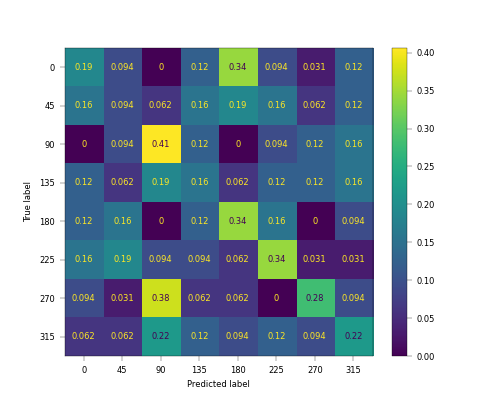

In [341]:
skmetrics.plot_confusion_matrix(trained_svc, test_data, test_labels, 
                                normalize='true')  

In [11]:
def wraper_func(func, **kwargs):
    output = func(**kwargs)
    return output

In [20]:
def func1(x='Func1', y='Alt1', z='Extra1'):
    res = '%s_%s_%s' % (x, y, z)
    return res

def func2(x='Func2', y='Alt2', w='Extra2'):
    res = '%s_%s_%s' % (x, y, z)
    r2 = 'andthis'
    return res, r2

In [23]:
inargs = {'x': 'check1', 'z': 'check2'}
inargs = (x='check1', y='check2')
res = wraper_func(func1, **inargs)
res

SyntaxError: invalid syntax (<ipython-input-23-0a6f99e4a23c>, line 2)

In [22]:
res = wraper_func(func2, **inargs)
res

TypeError: func2() got an unexpected keyword argument 'z'

In [ ]:
decode_from_fov(dk, va, neuraldf, sdf, C_value=C_value,
                        n_iterations=n_iterations, n_processes=n_processes, results_id=results_id,
                        class_a=class_a, class_b=class_b, do_shuffle=do_shuffle,
                        rootdir=rootdir, verbose=verbose,
                        test_type=test_type, n_train_configs=n_train_configs) 
            print("--- done by_fov ---")